In [99]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels import api as sm
from statsmodels.graphics import tsaplots

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

pd.options.display.float_format = '{:.2f}'.format

1. Загрузите данные из источника по ссылке, ознакомьтесь с ними и подготовьте к аналитике

        Найдите и удалите пропуски, если они есть.

        Поменяйте тип столбца с временными отсечками в datetime.

        Установите индексом данных столбец с временными отсечками и убедитесь, что он монотонно возрастает.

In [124]:
data = pd.read_csv('AirPassengers.csv', sep=',')

In [101]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [102]:
data.info() #пропусков нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [126]:
data['Month'] = pd.to_datetime(data['Month'], format="%Y-%m")

In [127]:
data.set_index('Month', inplace=True) # проиндексировал колонку с временем

In [105]:
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [128]:
data.index.is_monotonic_increasing # проверил находятся ли данные в хронологическом порядке

True

2. Проанализируйте временной ряд

        Оставьте для аналитики лишь с 1952 по 1957 год (включительно).

        Реализуйте разложение на компоненты тренда и сезонности. Визуализируйте результат разложения и сделайте выводы.

        Есть ли тренд?

        Есть ли сезонность и какая она (ежемесячная/ежеквартальная/ежегодная и т.д.)?

        Является ли ряд стационарным и почему?

        Постройте график, чтобы оценить автокорреляцию и сделайте выводы

        У какого сдвига самая высокая автокорреляция?

        Подтверждаются ли выводы о наличии тренда графиком автокорреляции?

In [107]:
data = data['1952':'1957']
print(data.index.min(), data.index.max()) # Убрал лишние данные

1952-01-01 00:00:00 1957-12-01 00:00:00


In [108]:
decompose = seasonal_decompose(data) # разложение временного ряда на: тренд сезонность остаток

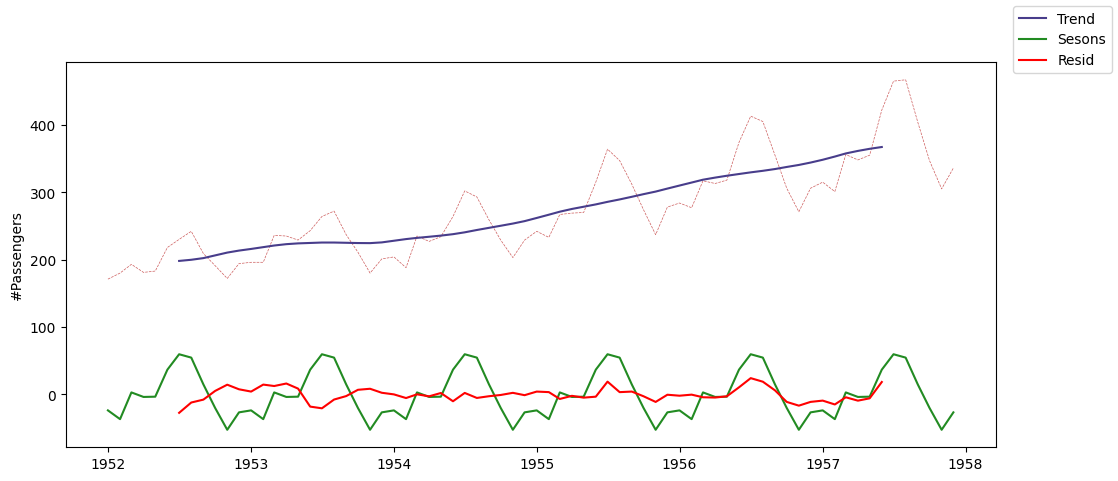

In [109]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])
ax.plot(data['#Passengers'], c='indianred', linewidth = 0.5, linestyle='--')
ax.plot(decompose.trend, c='darkslateblue', label = 'Trend')
ax.plot(decompose.seasonal, c='forestgreen', label = 'Sesons')
ax.plot(decompose.resid , c='red', label = 'Resid')
ax.set_ylabel('#Passengers')

fig.legend()


    В данных наблюдается сезонность.
    В данных наблюдается тренд на повышение количества пассажиров.
    Ряд является стационарным, так как распределение со временем не меняется.

In [110]:
sales_diffs = data - data.shift(fill_value=0)


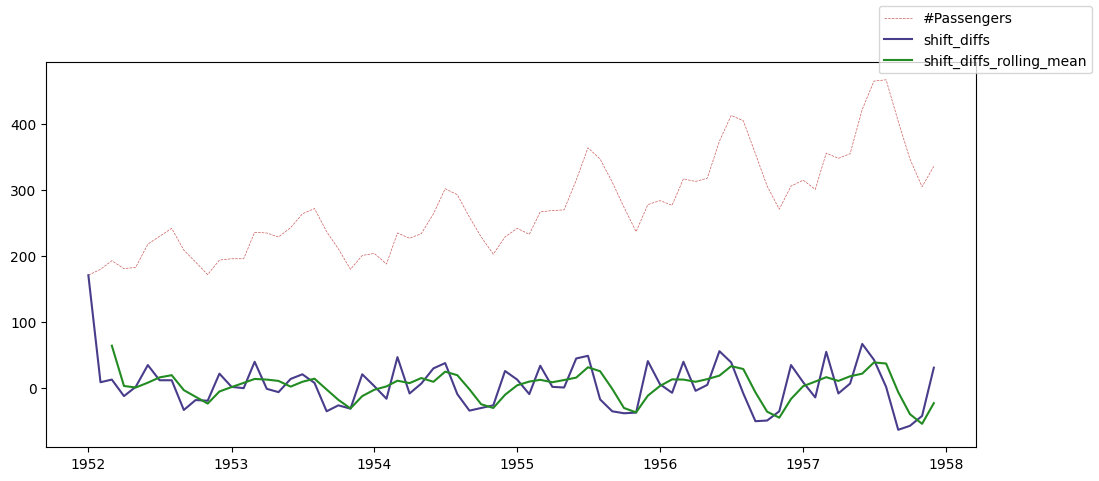

In [111]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

ax.plot(data, c='indianred', linewidth = 0.5, linestyle='--', label = '#Passengers')
ax.plot(sales_diffs, c='darkslateblue', label = 'shift_diffs')
ax.plot(sales_diffs.rolling(3).mean(), c='forestgreen', label = 'shift_diffs_rolling_mean') # скользящее среднее

fig.legend()

In [112]:
acf = sm.tsa.acf(data['#Passengers'])
acf.shape

(19,)

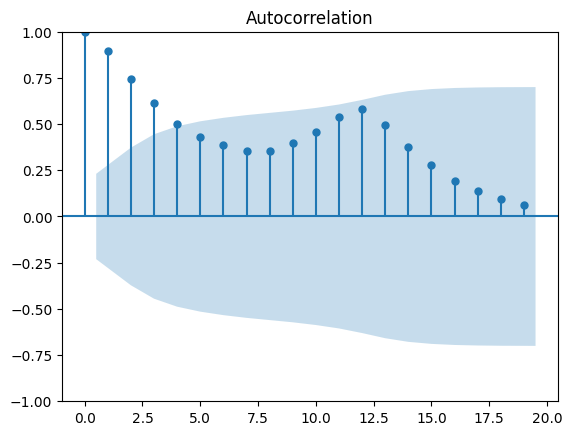

In [113]:
fig = tsaplots.plot_acf(data['#Passengers'])
plt.show()

    Самая высокая автокорреляция на первом месяцев
    Наличие сезонности можно заметить по сдвигу на 12 месяце

In [114]:
def make_features(data, lag_shifts, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['quarter'] = data.index.quarter
    
    for lag in lag_shifts:
        data[f'lag_{lag}'] = data['#Passengers'].shift(lag)

    for size in rolling_mean_size:
        rolling_mean    = data['#Passengers'].rolling(size).mean()
        data[f'rolling_mean_{size}'] = rolling_mean.shift(1 )
    
    return data

In [115]:
lag_shifts = range(1,10)
rolling_mean_size = [2,4,6,8,12]

data_with_features = make_features(data.copy(),lag_shifts,rolling_mean_size)
data_with_features.head(10)

,#Passengers,year,month,quarter,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean_2,rolling_mean_4,rolling_mean_6,rolling_mean_8,rolling_mean_12
Month,,,,,,,,,,,,,,,,,,
1952-01-01,171,1952,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952-02-01,180,1952,2,1,171.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952-03-01,193,1952,3,1,180.00,171.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,175.50,NaN,NaN,NaN,NaN
1952-04-01,181,1952,4,2,193.00,180.00,171.00,NaN,NaN,NaN,NaN,NaN,NaN,186.50,NaN,NaN,NaN,NaN
1952-05-01,183,1952,5,2,181.00,193.00,180.00,171.00,NaN,NaN,NaN,NaN,NaN,187.00,181.25,NaN,NaN,NaN
1952-06-01,218,1952,6,2,183.00,181.00,193.00,180.00,171.00,NaN,NaN,NaN,NaN,182.00,184.25,NaN,NaN,NaN
1952-07-01,230,1952,7,3,218.00,183.00,181.00,193.00,180.00,171.00,NaN,NaN,NaN,200.50,193.75,187.67,NaN,NaN
1952-08-01,242,1952,8,3,230.00,218.00,183.00,181.00,193.00,180.00,171.00,NaN,NaN,224.00,203.00,197.50,NaN,NaN
1952-09-01,209,1952,9,3,242.00,230.00,218.00,183.00,181.00,193.00,180.00,171.00,NaN,236.00,218.25,207.83,199.75,NaN


In [116]:
train, test = train_test_split(data_with_features.dropna(), shuffle=False, test_size=0.2)
train = train.dropna()

train_target = train['#Passengers']
train_features = train.drop(['#Passengers'], axis=1)
test_target = test['#Passengers']
test_features = test.drop(['#Passengers'], axis=1)

scaler = StandardScaler().fit(train_features)
train_features_norm = scaler.transform(train_features)
test_features_norm = scaler.transform(test_features)

model = LinearRegression()
model.fit(train_features_norm, train_target)

train_prediction = pd.Series(model.predict(train_features_norm))
train_prediction.index = train_features.index
test_prediction = pd.Series(model.predict(test_features_norm))
test_prediction.index = test_features.index

print(f'MAE обучающей выборки: {mean_absolute_error(train_target, train_prediction)}')
print(f'MAE тестовой выборки: {mean_absolute_error(test_target, test_prediction)}')


MAE обучающей выборки: 10.154867784982029
MAE тестовой выборки: 13.278678553358526


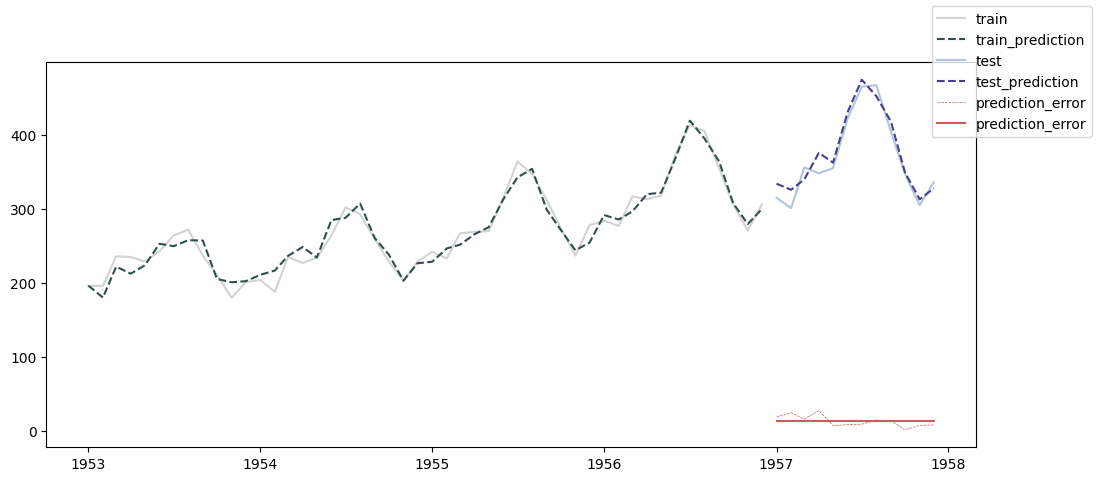

In [117]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

error = abs(test['#Passengers'] - test_prediction)
error_mean = pd.Series([error.mean()] * error.shape[0])
error_mean.index = test.index

ax.plot(train_target, c='lightgrey', label='train')
ax.plot(train_prediction, c='darkslategrey', label='train_prediction', linestyle='--')
ax.plot(test_target, c='lightsteelblue', label='test')
ax.plot(test_prediction, c='darkslateblue', label='test_prediction', linestyle='--')
ax.plot(error, c='indianred', linestyle='--', label='prediction_error', linewidth=0.5)
ax.plot(error_mean, c='indianred', label='prediction_error')

fig.legend();

In [136]:
data_val = data['1958':'1961']

In [137]:
lag_shifts = range(1,10)
rolling_mean_size = [2,4,6,8,12]

data_val_with_features = make_features(data_val.copy(),lag_shifts,rolling_mean_size)
data_val_with_features.head(10)

,#Passengers,year,month,quarter,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean_2,rolling_mean_4,rolling_mean_6,rolling_mean_8,rolling_mean_12
Month,,,,,,,,,,,,,,,,,,
1958-01-01,340,1958,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1958-02-01,318,1958,2,1,340.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1958-03-01,362,1958,3,1,318.00,340.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,329.00,NaN,NaN,NaN,NaN
1958-04-01,348,1958,4,2,362.00,318.00,340.00,NaN,NaN,NaN,NaN,NaN,NaN,340.00,NaN,NaN,NaN,NaN
1958-05-01,363,1958,5,2,348.00,362.00,318.00,340.00,NaN,NaN,NaN,NaN,NaN,355.00,342.00,NaN,NaN,NaN
1958-06-01,435,1958,6,2,363.00,348.00,362.00,318.00,340.00,NaN,NaN,NaN,NaN,355.50,347.75,NaN,NaN,NaN
1958-07-01,491,1958,7,3,435.00,363.00,348.00,362.00,318.00,340.00,NaN,NaN,NaN,399.00,377.00,361.00,NaN,NaN
1958-08-01,505,1958,8,3,491.00,435.00,363.00,348.00,362.00,318.00,340.00,NaN,NaN,463.00,409.25,386.17,NaN,NaN
1958-09-01,404,1958,9,3,505.00,491.00,435.00,363.00,348.00,362.00,318.00,340.00,NaN,498.00,448.50,417.33,395.25,NaN


In [138]:
val = data_val_with_features.dropna()

val_target = val['#Passengers']
val_features = val.drop(['#Passengers'], axis=1)

val_features_norm = scaler.transform(val_features)

val_prediction = pd.Series(model.predict(val_features_norm))
val_prediction.index = val_features.index

print(f'MAE отложенной выборки: {mean_absolute_error(val_target, val_prediction)}')

MAE отложенной выборки: 25.58140695990439


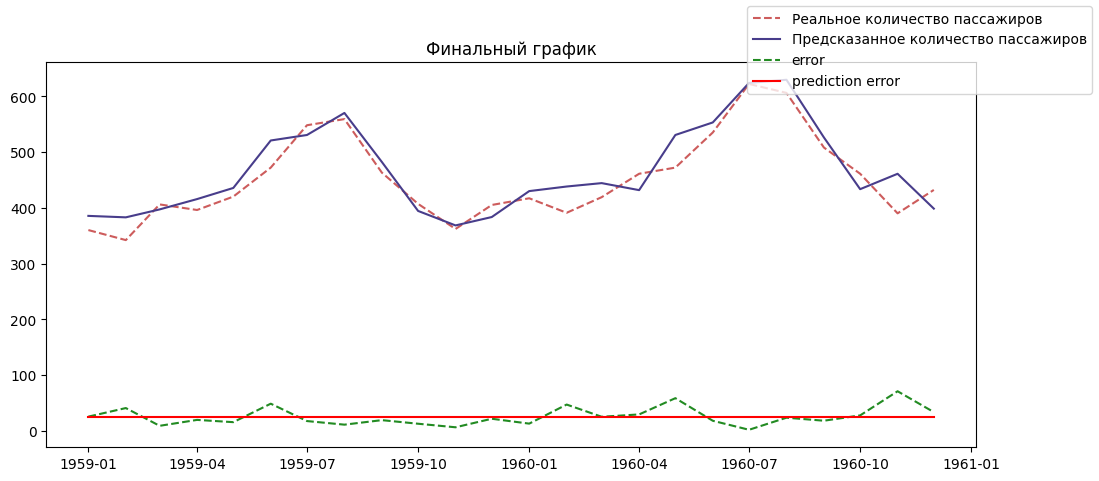

In [141]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

error = abs(val['#Passengers'] - val_prediction)
error_mean = pd.Series([error.mean()]* error.shape[0])
error_mean.index = val.index

ax.plot(val_target, c='indianred', label = 'Реальное количество пассажиров', linestyle = '--')
ax.plot(val_prediction, c='darkslateblue', label = 'Предсказанное количество пассажиров')
ax.plot(error, c='forestgreen', label = 'error', linestyle = '--')
ax.plot(error_mean, c = 'red', label = 'prediction error')
ax.set_title('Финальный график')

fig.legend()